In [28]:
%matplotlib inline
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from matplotlib import gridspec
from pyunlocbox import functions, solvers
import pygsp as pg
import networkx as nx

# import our own functions
from our_functions import get_true_labels, find_components, find_largest_component, \
give_names_tonodes_dates_based, num_nodes, connected_graph, compute_shortest_path_lengths
from fragmentation_measures import num_disconnected_components, F_measure, information_entropy, Fd_measure
from optimization_algorithms import find_key_terrorists_fragmentation, find_key_terrorists_flow

import random
import itertools


# Extracting Terrorist Names from Nodes

In [2]:
A = np.load('adjacency.npy')

# get the largest component
A, size = find_largest_component(find_components(A))

n_nodes = size
n_edges = np.count_nonzero(A) / 2

# get terrorist names for each node
names, A, name_dict = give_names_tonodes_dates_based(A)

# get relation label for each node
labels = get_true_labels(A)

# Graph Inversion

Number of unique terrorist: 244


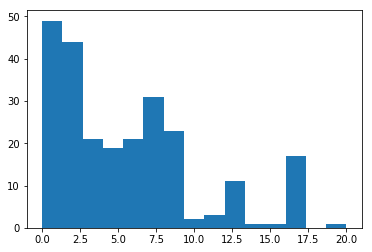

In [3]:
# Number of unique terrorists
num_terrorist = len(name_dict.keys())
print("Number of unique terrorist: {n:}".format(n=num_terrorist))

# Array of terrorist names 
all_names = np.array(list(name_dict.keys()))

# Initialize inverted adjacency matrix. Symmetric and unweighted by default.
A_inverted = np.zeros((num_terrorist, num_terrorist))
A_relations = np.zeros((num_terrorist, num_terrorist))

for n in range(n_nodes):
    temp = []
    for d, name in enumerate(list(name_dict.keys())):
        if n in list(name_dict.values())[d]:
            # collect all terrorist names that correspond to node n: will ALWAYS be at most length 2
            temp.append(list([name]))

    for k in range(len(temp)):
        for j in range(len(temp)):
            if k >= j: continue
            idx = np.where(all_names == temp[k])[0][0]
            idx2 = np.where(all_names == temp[j])[0][0]
            
            # create an edge between all terrorists that belonged to the same node in original graph
            A_inverted[idx,idx2] = 1
            A_inverted[idx2,idx] = 1
            
            # create a matrix which stores corresponding relations between terrorists             
            A_relations[idx,idx2] = int(labels[n])
            A_relations[idx2,idx] = int(labels[n])
            
plt.hist(np.sum(A_inverted,axis=1), bins=15)
plt.show()

### Largest Component of Inverted Graph

Number of disconnected components: 30


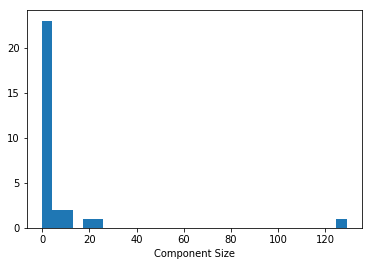

Size of inverted graph: 244
Size of largest component: 129


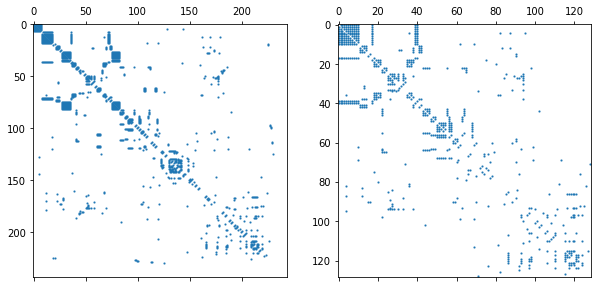

In [4]:
# Find the largest component
components = find_components(A_inverted)
largest_cc_inv, size = find_largest_component(components)

# Remove all-zero indices
zero_index = np.where(np.sum(largest_cc_inv, axis=0) == 0)[0]
largest_cc_inv = np.delete(largest_cc_inv, zero_index, axis=0)
largest_cc_inv = np.delete(largest_cc_inv, zero_index, axis=1)
relations_largest_cc = np.delete(A_relations, zero_index, axis=0)
relations_largest_cc = np.delete(relations_largest_cc, zero_index, axis=1)
names_largest_cc = np.delete(all_names, zero_index)

print("Number of disconnected components: {d:}".format(d=len(components)))
deg_dist = []
for c in range(len(components)):
    deg_dist.append(num_nodes(components[c]))

plt.hist(deg_dist, bins=len(components))
plt.xlabel('Component Size')
plt.show()

print("Size of inverted graph: {s:}".format(s=num_terrorist))
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax1.spy(A_inverted, markersize=1)

print("Size of largest component: {s:}".format(s=size))
ax2 = fig.add_subplot(122)
ax2.spy(largest_cc_inv, markersize=1)

In [5]:
display = False
if display:
    for idx, name in enumerate(names):
        print(name)
        for i in range(A.shape[0]):
            if A[idx, i] == 1:
                print("\t"+str(names[i]))

### Boxplots visualization of "fragmentation" measures

### Determine if any of the above measures are positively correlated

# Identify Key Players for Information Flow
In this section, we identify a set of key players that are central for information flow within the network. This implies that without them, communication within the network is disrupted effectively. Metrics that help us evaluate this property include (all normalized):
- (group) degree centrality
- (group) closeness centrality
- (group) betweenness centrality

Source: http://steveborgatti.com/papers/cmotkeyplayer.pdf

In [6]:
# Degree centrality
degrees = np.sum(largest_cc_inv,axis=1) / largest_cc_inv.shape[0]

# convert adjacency matrix to networkx graph object
G = nx.from_numpy_matrix(largest_cc_inv)

# Closeness centrality
closeness = np.array(list(nx.closeness_centrality(G).values()))
closeness_n = closeness/(max(closeness))

# Betweenness centrality
between = np.array(list(nx.betweenness_centrality(G).values()))
between_n = between/(max(between))


#### SET OF NODES WITH HIGHER VALUES OF CENTRALITY MEASURES

In [7]:
# Set of 5 nodes with higher betweenness centrality value
between_sorted = np.sort(between)[::-1]
n_higher_between = [np.where(between == between_sorted[i])[0][0] for i in range(5)]

# Set of 5 nodes with higher closeness centrality value
closeness_sorted = np.sort(closeness)[::-1]
n_higher_closeness = [np.where(closeness == closeness_sorted[i])[0][0] for i in range(5)]

# Set of 5 nodes with higher degress centrality value
degrees_sorted = np.sort(degrees)[::-1]
n_higher_degrees = [np.where(degrees == degrees_sorted[i])[0][0] for i in range(3)]

print('Nodes with higher Betweenness centrality: ', n_higher_between)
print("Corresponding names: \n", all_names[n_higher_between], "\n")
print('Nodes with higher Closeness centrality:   ', n_higher_closeness)
print("Corresponding names: \n", all_names[n_higher_closeness], "\n")
print('Nodes with higher Degree centrality:      ', n_higher_degrees)
print("Corresponding names: \n", all_names[n_higher_degrees], "\n")

Nodes with higher Betweenness centrality:  [26, 38, 93, 18, 63]
Corresponding names: 
 ['/2005/09/08/03:44:31' '/2005/10/20/19:57:58' 'Lionel_Dumont'
 'AbbasSayyed' 'Yoshiro_Inoue'] 

Nodes with higher Closeness centrality:    [26, 38, 93, 94, 27]
Corresponding names: 
 ['/2005/09/08/03:44:31' '/2005/10/20/19:57:58' 'Lionel_Dumont'
 'Omar_Zemmiri' 'Mohamed_el_Bousklaoui'] 

Nodes with higher Degree centrality:       [4, 10, 17]
Corresponding names: 
 ['Abu_Jalal_Iraqi' 'Abu_Marzuq' '/2005/09/08/04:57:12'] 



### Boxplots visualization of centrality measures

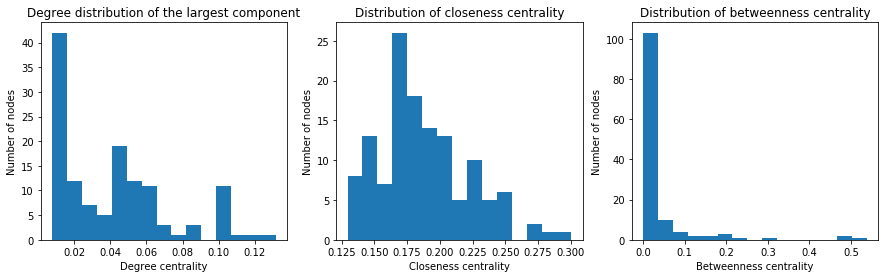

In [8]:
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(131)
ax1.hist(degrees, bins=15)
ax1.set_xlabel("Degree centrality")
ax1.set_ylabel("Number of nodes")
ax1.set_title("Degree distribution of the largest component")

ax2 = fig.add_subplot(132)
ax2.hist(closeness, bins=15)
ax2.set_xlabel("Closeness centrality")
ax2.set_ylabel("Number of nodes")
ax2.set_title("Distribution of closeness centrality")

ax3 = fig.add_subplot(133)
ax3.hist(between, bins=15)
ax3.set_xlabel("Betweenness centrality")
ax3.set_ylabel("Number of nodes")
ax3.set_title("Distribution of betweenness centrality")
plt.show()

### Determine if any of centrality measures are positively correlated

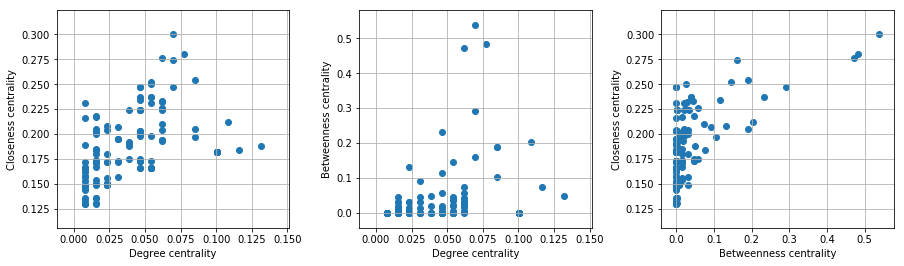

In [9]:
# Note that only betweenness and closeness centralities are (relatively) positively correlated

fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(131)
ax1.scatter(degrees, closeness)
ax1.set_xlabel("Degree centrality")
ax1.set_ylabel("Closeness centrality")

ax2 = fig.add_subplot(132)
ax2.scatter(degrees, between)
ax2.set_xlabel("Degree centrality")
ax2.set_ylabel("Betweenness centrality")

ax3 = fig.add_subplot(133)
ax3.scatter(between, closeness)
ax3.set_xlabel("Betweenness centrality")
ax3.set_ylabel("Closeness centrality")

plt.subplots_adjust(wspace=0.3)

ax1.grid()
ax2.grid()
ax3.grid()

# Greedy Optimization Algorithm

In [10]:
# Find key terrorist for spreading information along the network. 
objective, nodes_sets = find_key_terrorists_flow(largest_cc_inv, reg=0.5)

for i in range(len(objective)):
    print('Score achieved by set of size {}: '.format(len(nodes_sets[i]), objective[i]))
    print("List of name of key terrorists:")
    for j in nodes_sets[i]:
        print('Node number: {}. Node ID: {}'.format(j, all_names[j]))
    print("\n")
    


Exploring sets of 2 terrorists...



Best score achieved with 2 people: 4.905426356589148
Exploring sets of 3 terrorists...



Best score achieved with 3 people: 4.557364341085272
Exploring sets of 4 terrorists...



Best score achieved with 4 people: 4.593023255813954
Score achieved by set of size 2: 
List of name of key terrorists:
Node number: 4. Node ID: Abu_Jalal_Iraqi
Node number: 26. Node ID: /2005/09/08/03:44:31


Score achieved by set of size 3: 
List of name of key terrorists:
Node number: 27. Node ID: Mohamed_el_Bousklaoui
Node number: 63. Node ID: Yoshiro_Inoue
Node number: 87. Node ID: /2005/10/28/02:53:16


Score achieved by set of size 4: 
List of name of key terrorists:
Node number: 17. Node ID: /2005/09/08/04:57:12
Node number: 63. Node ID: Yoshiro_Inoue
Node number: 90. Node ID: Karim_Said_Atmani
Node number: 94. Node ID: Omar_Zemmiri




Number of key terrorists for fragmentation: 3


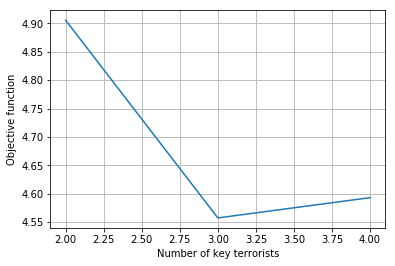

In [34]:
print("Number of key terrorists for fragmentation: {n:}".format(n=len(nodes_sets)))
#print("List of the names of the key terrorists for fragmentation: \n", all_names[set_kt[:-1]])
plt.plot([2, 3, 4], objective)
plt.xlabel("Number of key terrorists")
plt.ylabel("Objective function")
plt.grid()
plt.show()

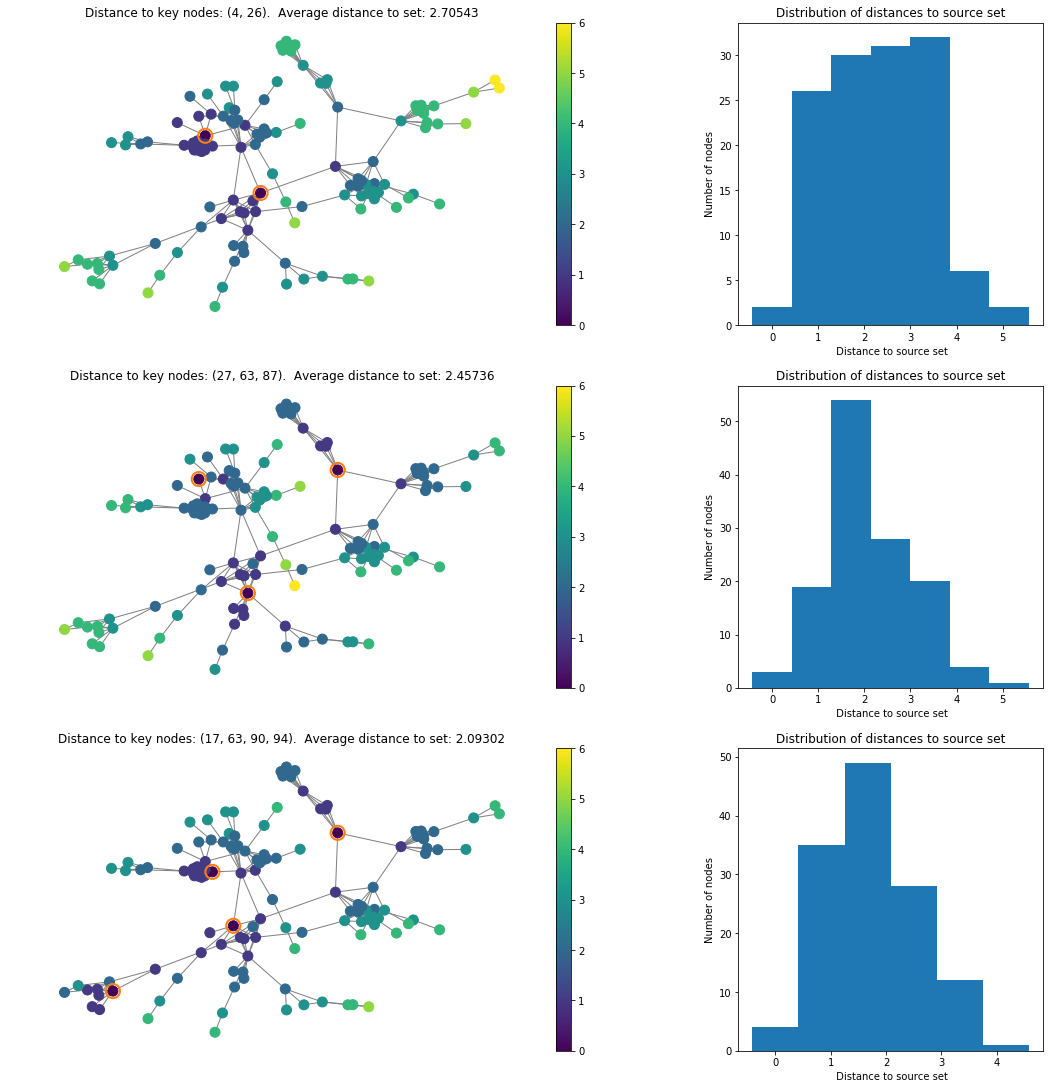

In [117]:
# Create pygsp graph for visualization
G_flow = pg.graphs.Graph(largest_cc_inv)
G_flow.set_coordinates('spring')
fig = plt.figure(figsize=(18, 21))
gs = gridspec.GridSpec(3, 2, width_ratios=[2, 1], bottom=0.2) 

G = nx.from_numpy_matrix(largest_cc_inv)
# Compute distances between all nodes
distance_matrix = np.asarray(nx.floyd_warshall_numpy(G))

max_d = 6
i = 0
for set_kt_flow in nodes_sets:
    distance = np.minimum(distance_matrix[set_kt_flow[0],:], distance_matrix[set_kt_flow[1],:] )
    for j in range(2, len(set_kt_flow)):
        # Update distance as minimum between the new node and the set
        distance = np.minimum(distance_matrix[set_kt_flow[j], :], distance)
    
    # Plot distnaces on graph
    ax = plt.subplot(gs[i])
    G_flow.plot_signal(distance, colorbar=True, ax=ax, highlight=np.where(distance ==0), limits=[0,max_d])
    title = r'Distance to key nodes: {}.  Average distance to set: {}'.format(set_kt_flow, round(np.mean(distance), 5))
    _ = ax.set_title(title)
    ax.set_axis_off()
    
    # Plot distribution of distances
    ax2 = plt.subplot(gs[i+1])
    ax2.hist(distance, bins=1+int(np.max(distance)), histtype='stepfilled', align='left')
    _ = ax2.set_title('Distribution of distances to source set')
    ax2.set_ylabel('Number of nodes')
    ax2.set_xlabel(' Distance to source set')
    i += 2

### COMPARISON OF PERFORMANCE BETWEEN BEST SET FOUND AND NODES WITH HIGHEST CENTRALITY VALUES

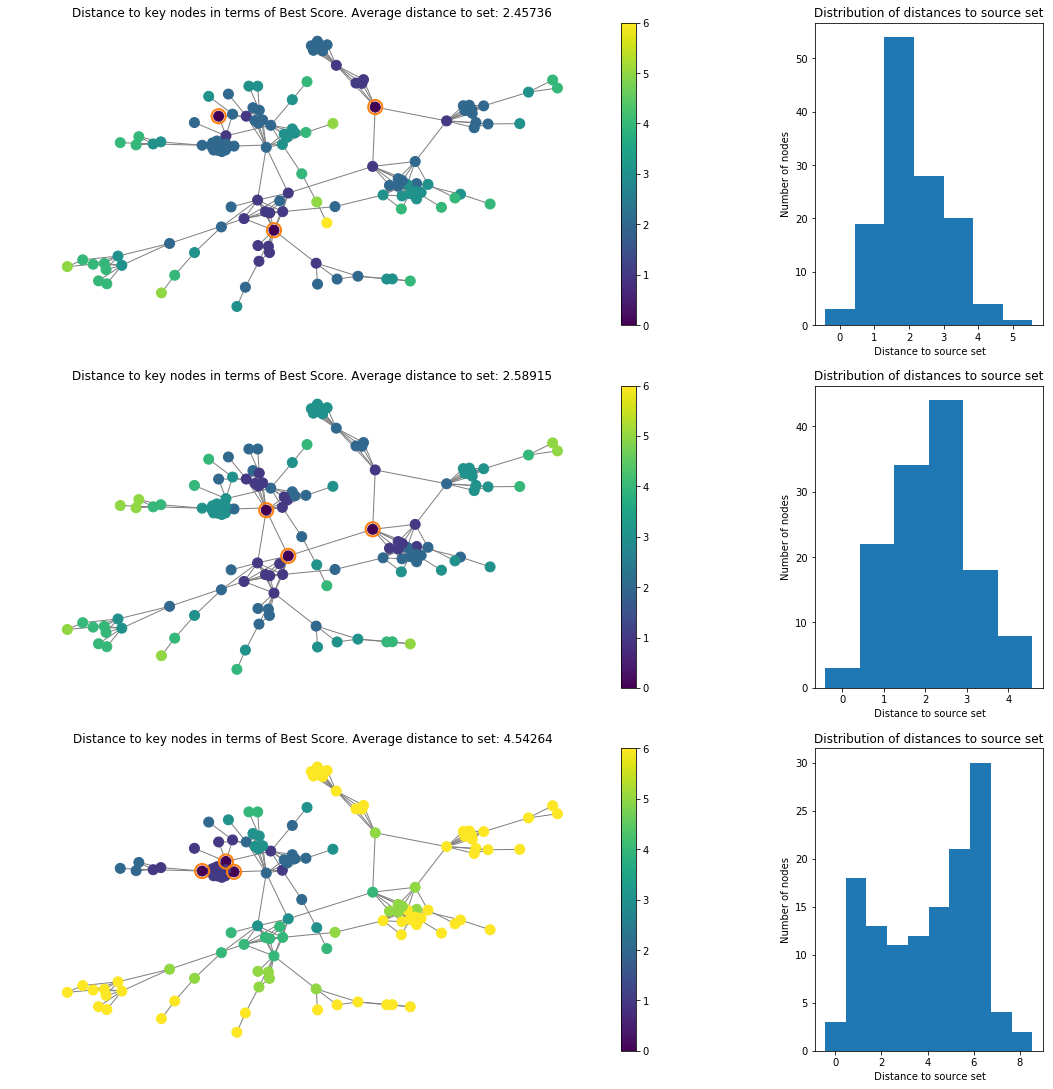

In [144]:
# Create pygsp graph for visualization

fig = plt.figure(figsize=(18, 21))
gs = gridspec.GridSpec(3, 2, width_ratios=[3, 1], bottom=0.2) 


size_set = len(nodes_sets[np.argmin(objective)])
sets_to_compare = [list(nodes_sets[np.argmin(objective)])]

# Select sets of same size as best performing 
sets_to_compare.append([np.where(between == between_sorted[i])[0][0] for i in range(size_set)])
sets_to_compare.append([np.where(degrees == degrees_sorted[i])[0][0] for i in range(size_set)])

# Betweennes centrality and closeness centrality result in the same subset. Avoid plotting both for better visualization
#sets_to_compare.append([np.where(closeness == closeness_sorted[i])[0][0] for i in range(size_set)])



titles = ['Best Score', 'Highest Betweenness Centrality', 'Highest Degree Centrality']
max_d = 6
i = 0
for set_kt_flow in sets_to_compare:
    # Compute all distances
    distance = np.minimum(distance_matrix[set_kt_flow[0],:], distance_matrix[set_kt_flow[1],:] )
    for j in range(2, len(set_kt_flow)):
        # Update distance as minimum between the new node and the set
        distance = np.minimum(distance_matrix[set_kt_flow[j], :], distance)
    
    
    # Plot distnaces on graph
    ax = plt.subplot(gs[i])
    G_flow.plot_signal(distance, colorbar=True, ax=ax, highlight=np.where(distance ==0), limits=[0,max_d])
    title = r"Distance to key nodes in terms of {}. Average distance to set: {}".format(titles[int(i%2)], round(np.mean(distance), 5))
    _ = ax.set_title(title)
    ax.set_axis_off()
    
    # Plot distribution of distances
    ax2 = plt.subplot(gs[i+1])
    ax2.hist(distance, bins=1+int(np.max(distance)), histtype='stepfilled', align='left')
    _ = ax2.set_title('Distribution of distances to source set')
    ax2.set_ylabel('Number of nodes')
    ax2.set_xlabel(' Distance to source set')
    i += 2

##### COMMENT ON THE RESULTS:

The plot shows for different criterias of selection, the distance for each node to the set of nodes considered key as well as the distribution of values of these distances. 

In the plot of distance values over the graph, nodes colored in yellow represent those with distance equal or greater than 6 which is the maximum distance in the network to the set obtained through the greedy search.  

The results obtained with best degree score are complitely discarded as they yield a greater amount of nodes at high distance as well as a greater average distance. 

It is interesting to compare results between the set obtained through greedy search for optimizing the objective value and the ones with highest betweenness centrality.

In the first case, the set yields an average distance of 2.46 hops between any node in the network and the set. There is also one node located at the maximum distance of 6 hops. On the other side, the nodes with highest score on betweenness centrality yield a greater average distance although achieving a lower maximum distance. We face a trade-off between maximum distance and average that can be adjusted through the penalization parameter in the objective function to optimize. 

For the purpose of spreading missinformation in the network, it will be more interesting to pick a set with lower average to ensure the information arrives in the first steps to the most number of nodes. In practice, it will mean that, if the information spread was stopped earlier than expected, a higher number of nodes would have been missinformed by that time.

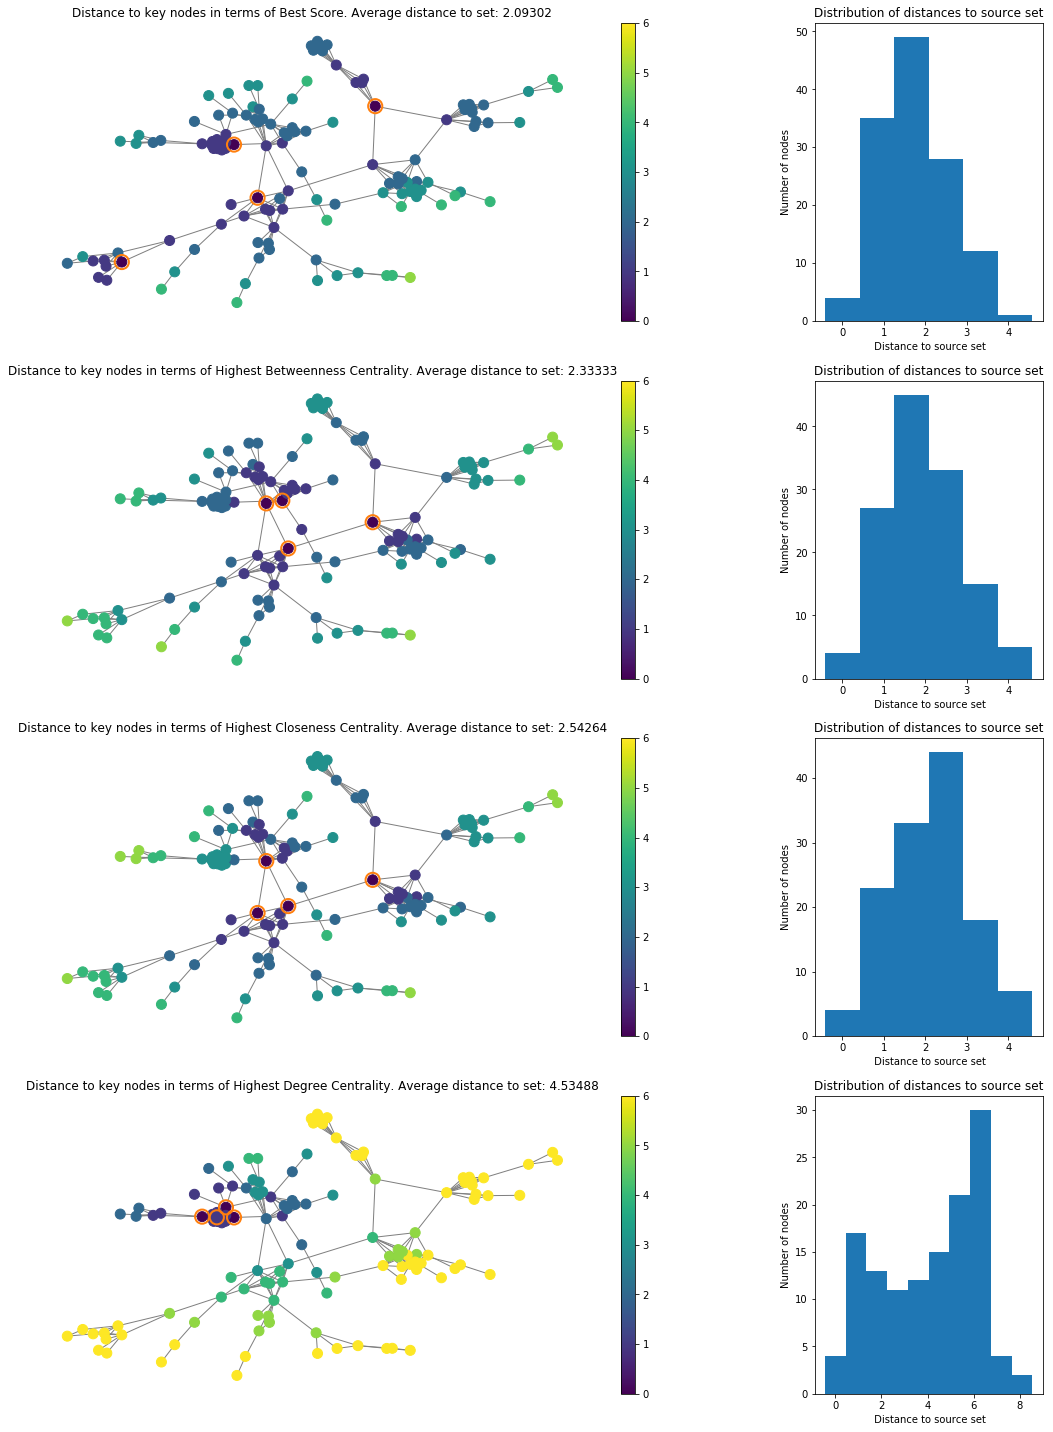

In [145]:
# Create pygsp graph for visualization
# VISUALIZATION OF COMPARISON FOR SETS OF 4 NODES! 


fig = plt.figure(figsize=(18, 28))
gs = gridspec.GridSpec(4, 2, width_ratios=[3, 1], bottom=0.2) 


size_set = 4
sets_to_compare = [list(nodes_sets[-1])]

# Select sets of same size as best performing 
sets_to_compare.append([np.where(between == between_sorted[i])[0][0] for i in range(size_set)])
sets_to_compare.append([np.where(closeness == closeness_sorted[i])[0][0] for i in range(size_set)])
sets_to_compare.append([np.where(degrees == degrees_sorted[i])[0][0] for i in range(size_set)])


titles = ['Best Score', 'Highest Betweenness Centrality', 'Highest Closeness Centrality',\
          'Highest Degree Centrality']
max_d = 6
i = 0
for set_kt_flow in sets_to_compare:
    # Compute all distances
    distance = np.minimum(distance_matrix[set_kt_flow[0],:], distance_matrix[set_kt_flow[1],:] )
    for j in range(2, len(set_kt_flow)):
        # Update distance as minimum between the new node and the set
        distance = np.minimum(distance_matrix[set_kt_flow[j], :], distance)
    
    #print('Average distance to set: {}'.format(np.mean(distance)))
    # Plot distnaces on graph
    ax = plt.subplot(gs[i])
    G_flow.plot_signal(distance, colorbar=True, ax=ax, highlight=np.where(distance ==0), limits=[0,max_d])
    title = r"Distance to key nodes in terms of {}. Average distance to set: {}".format(titles[int(i/2)], round(np.mean(distance), 5))
    _ = ax.set_title(title)
    ax.set_axis_off()
    
    # Plot distribution of distances
    ax2 = plt.subplot(gs[i+1])
    ax2.hist(distance, bins=1+int(np.max(distance)), histtype='stepfilled', align='left')
    _ = ax2.set_title('Distribution of distances to source set')
    ax2.set_ylabel('Number of nodes')
    ax2.set_xlabel(' Distance to source set')
    i += 2

### ANALYSIS WITH HEAT FILTER 

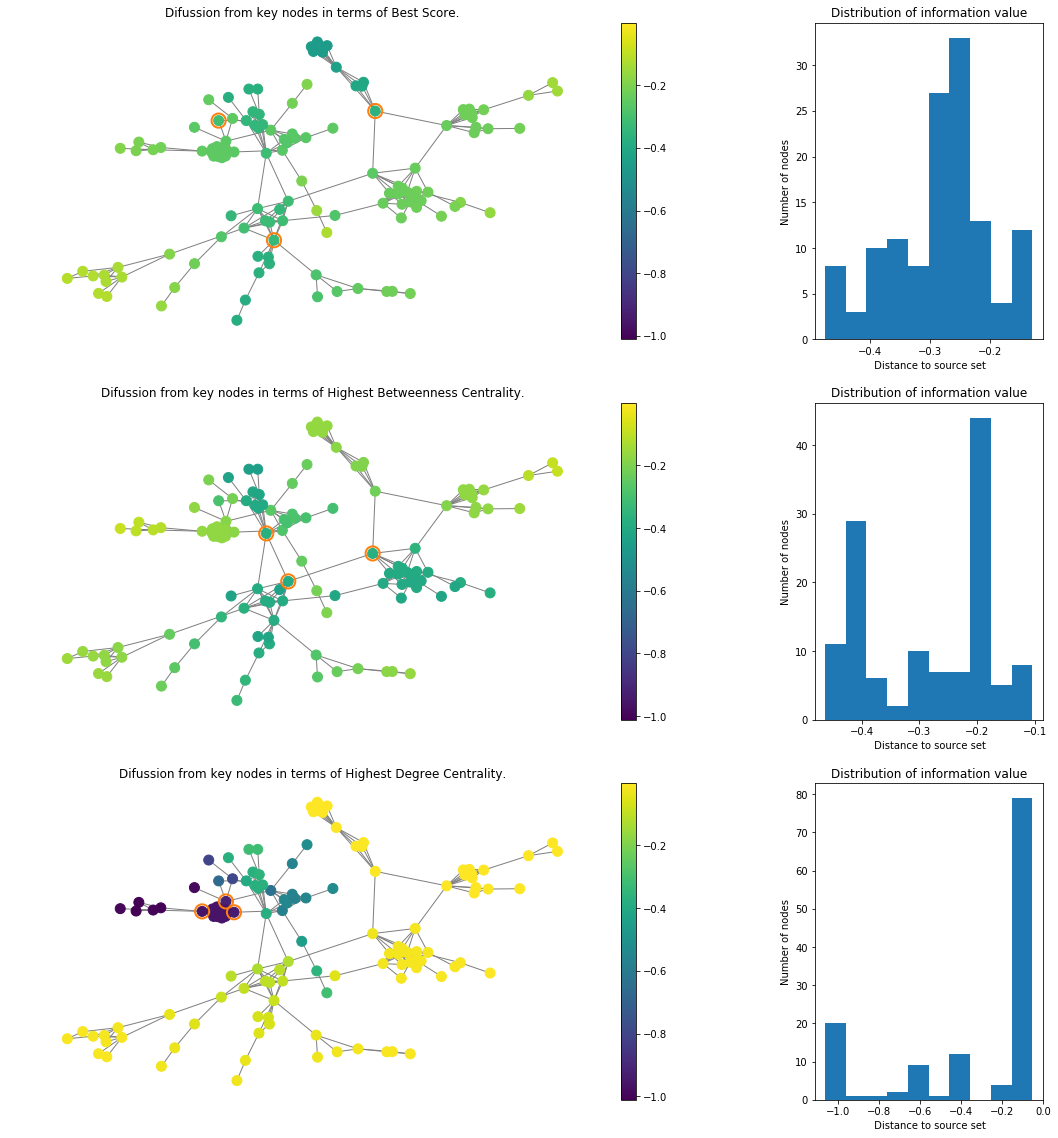

In [202]:
fig = plt.figure(figsize=(18, 22))
gs = gridspec.GridSpec(3, 2, width_ratios=[3, 1], bottom=0.2) 
#gs = gridspec.GridSpec(4, 2, bottom=0.2) 

size_set = 3
sets_to_compare = [list(nodes_sets[-2])]

# Select sets of same size as best performing 
sets_to_compare.append([np.where(between == between_sorted[i])[0][0] for i in range(size_set)])
sets_to_compare.append([np.where(degrees == degrees_sorted[i])[0][0] for i in range(size_set)])


titles = ['Best Score', 'Highest Betweenness Centrality', \
          'Highest Degree Centrality']
g = pg.filters.Heat(G_flow, 100)


difussion_signals = []
for set_kt_flow in sets_to_compare:
    # Compute all distances
    signal = np.zeros(len(G.nodes))
    for key_node in set_kt_flow:
        signal += -g.localize(key_node)
        
    difussion_signals.append(signal)
    #print('Average distance to set: {}'.format(np.mean(distance)))
    # Plot distnaces on graph
max_val = np.max(np.array(difussion_signals))
min_val = np.min(np.array(difussion_signals))
for i in range(0, 2*len(difussion_signals), 2):
    ax = plt.subplot(gs[i])
    G_flow.plot_signal(difussion_signals[int(i/2)], colorbar=True, ax=ax, \
                       highlight=sets_to_compare[int(i/2)], limits=[min_val,max_val])
    
    title = r"Difussion from key nodes in terms of {}."\
    .format(titles[int(i/2)])
    _ = ax.set_title(title)
    ax.set_axis_off()
    
    # Plot distribution of values of the signal
    ax2 = plt.subplot(gs[i+1])
    ax2.hist(difussion_signals[int(i/2)], histtype='stepfilled', align='left')
    _ = ax2.set_title('Distribution of information value')
    ax2.set_ylabel('Number of nodes')
    ax2.set_xlabel(' Distance to source set')
    



In [203]:
title = ['Best set optimization algorithm', 'Best set Betweenness centrality', 'Best set Degree']
for i, signal in enumerate(difussion_signals):
    print(title[i])
    print('Number of nodes with less information than the average: {}'. format(len(np.where(signal >= np.mean(signal))[0])))
    print('Number of nodes with low level of information: {}'. format(len(np.where(signal >= 0.25*np.min(signal))[0])))
    print('Number of nodes completely uninformed: {}'. format(len(np.where(signal >= -0.05)[0])))
    print('Number of nodes with high level of information: {}'. format(len(np.where(signal <= 0.9*np.min(signal))[0])))
    print("\n")

Best set optimization algorithm
Number of nodes with less information than the average: 82
Number of nodes with low level of information: 1
Number of nodes completely uninformed: 0
Number of nodes with high level of information: 8


Best set Betweenness centrality
Number of nodes with less information than the average: 71
Number of nodes with low level of information: 7
Number of nodes completely uninformed: 0
Number of nodes with high level of information: 19


Best set Degree
Number of nodes with less information than the average: 83
Number of nodes with low level of information: 83
Number of nodes completely uninformed: 68
Number of nodes with high level of information: 20




##### COMMENT ON THE RESULTS:

The plot shows the difussion of a signal using the heat kernel when a dirac impulse is placed on the nodes considered keys. To final value of the signal is given by the superposition of the filter evaluated at each node of the set individually. 

To ease the interpretation, the signal has been set to negative. Therefore, nodes with values close to zero mean they have not received much information while those with most negative values are properly informed nodes. 


The results obtained with best degree score yield a small community of nodes surrounding the sources that have almost the same level of information than the source nodes. Nevertheless, most of the nodes remain unaware of the information spread. 

It is interesting to compare results between the set obtained through greedy search for optimizing the objective value and the ones with highest betweenness centrality.

In both cases, there is no node remaining completely uninformed. 

With the set obtained via optimization, the values of amount of information per node along the network are normally distributed, achieving low values in the extremes (nodes with very high amount of information or with very low) and concentrating most of the nodes with a relatively average value. 

On the other side, feeding information through nodes with high betweenness centrality value leads to an unbalanced distribution, obtaining two peaks in both the extrems of the distribution. This behaviour is not really desired as the amount of nodes with very poor information remains quite high. 

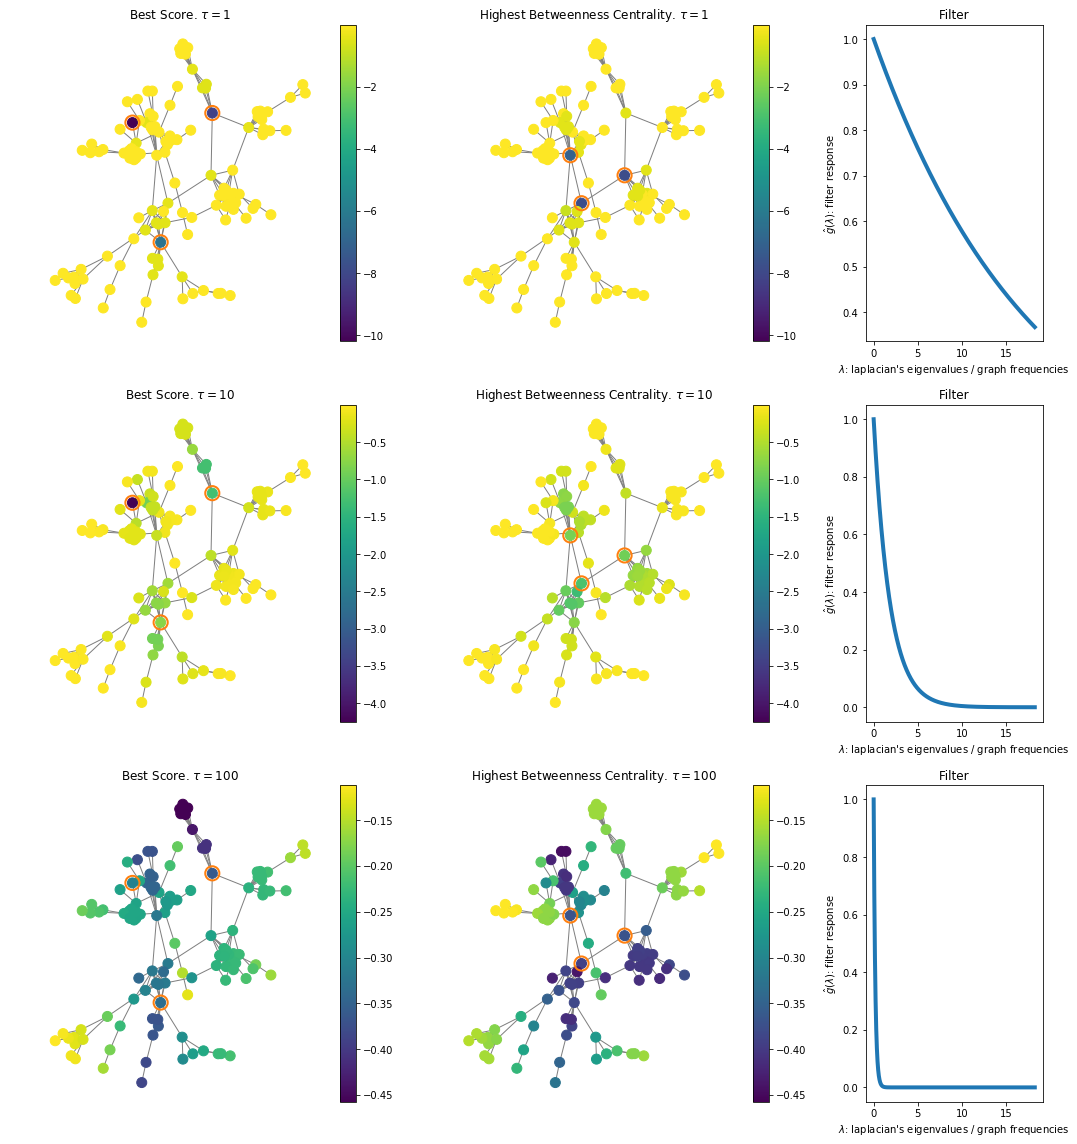

In [200]:
fig = plt.figure(figsize=(18, 22))
gs = gridspec.GridSpec(3, 3, width_ratios=[2, 2, 1], bottom=0.2) 
#gs = gridspec.GridSpec(4, 2, bottom=0.2) 

size_set = 3
sets_to_compare = [list(nodes_sets[-2])]

# Select sets of same size as best performing 
sets_to_compare.append([np.where(between == between_sorted[i])[0][0] for i in range(size_set)])


titles = ['Best Score', 'Highest Betweenness Centrality', 'Filter']
filters_g = [] 


difussion_signals = []
max_val = []
min_val = []
taus = [1, 10, 100]
for i, tau in enumerate(taus):
    g = pg.filters.Heat(G_flow, tau)
    filters_g.append(g)
    for set_kt_flow in sets_to_compare:
        # Compute signal
        signal = np.zeros(len(G.nodes))
        for key_node in set_kt_flow:
            signal += -g.localize(key_node)
        
        difussion_signals.append(signal)
    #print('Average distance to set: {}'.format(np.mean(distance)))
    # Plot distnaces on graph
    max_val.append(np.max(np.array(difussion_signals[i*2:i*2+1])))
    min_val.append(np.min(np.array(difussion_signals[i*2:i*2+1])))



for i in range(len(filters_g)):
    tau = taus[i]
    
    ax = plt.subplot(gs[i*3])
    G_flow.plot_signal(difussion_signals[i*2], colorbar=True, ax=ax, \
                       highlight=sets_to_compare[0], limits=[min_val[i],max_val[i]])
    
    title = r'{}. $\tau = {}$'\
    .format(titles[0], tau)
    _ = ax.set_title(title)
    ax.set_axis_off()
    
    ax1 = plt.subplot(gs[i*3+1])
    G_flow.plot_signal(difussion_signals[i*2 + 1], colorbar=True, ax=ax1, \
                       highlight=sets_to_compare[1], limits=[min_val[i],max_val[i]])
    
    title = r'{}. $\tau = {}$'\
    .format(titles[1], tau)
    _ = ax1.set_title(title)
    ax1.set_axis_off()
    
    # Plot distribution of values of the signal
    ax2 = plt.subplot(gs[i*3+2])
    filters_g[i].plot(ax=ax2)
    _ = ax2.set_title(titles[2])